In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import shap# data processing, CSV file I/O (e.g. pd.read_csv)
import lime
import lime.lime_tabular

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-income-dataset/adult.data
/kaggle/input/adult-income-dataset/adult.names
/kaggle/input/adult-income-dataset/Index
/kaggle/input/adult-income-dataset/old.adult.names
/kaggle/input/adult-income-dataset/adult.test


In [112]:
%pip install dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 44.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
"""with open('/kaggle/input/adult-income-dataset/old.adult.names','r') as f:
    print(f.read())
    """

"with open('/kaggle/input/adult-income-dataset/old.adult.names','r') as f:\n    print(f.read())\n    "

In [3]:
with open('/kaggle/input/adult-income-dataset/adult.names','r') as f:
    print(f.read())

| This data was extracted from the census bureau database found at
| http://www.census.gov/ftp/pub/DES/www/welcome.html
| Donor: Ronny Kohavi and Barry Becker,
|        Data Mining and Visualization
|        Silicon Graphics.
|        e-mail: ronnyk@sgi.com for questions.
| Split into train-test using MLC++ GenCVFiles (2/3, 1/3 random).
| 48842 instances, mix of continuous and discrete    (train=32561, test=16281)
| 45222 if instances with unknown values are removed (train=30162, test=15060)
| Duplicate or conflicting instances : 6
| Class probabilities for adult.all file
| Probability for the label '>50K'  : 23.93% / 24.78% (without unknowns)
| Probability for the label '<=50K' : 76.07% / 75.22% (without unknowns)
|
| Extraction was done by Barry Becker from the 1994 Census database.  A set of
|   reasonably clean records was extracted using the following conditions:
|   ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
|
| Prediction task is to determine whether a person makes over

In [4]:
columns = ['age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income']

In [5]:
df_test = pd.read_csv('/kaggle/input/adult-income-dataset/adult.test',names = columns,comment='|')#skiprows = 1
df_train = pd.read_csv('/kaggle/input/adult-income-dataset/adult.data',names = columns)

In [6]:
df_test.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


In [7]:
df_train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
print(df_test.shape)
print(df_train.shape)

(16281, 15)
(32561, 15)


In [9]:
df_test.drop(columns = ['fnlwgt','education'],inplace=True)
df_train.drop(columns = ['fnlwgt','education'],inplace=True)

In [10]:
maps = {' <=50K':0,' >50K':1,' <=50K.':0,' >50K.':1}
def mapping(df):
    return maps[df]

In [11]:
df_train['income'] = df_train['income'].apply(mapping)
df_test['income'] = df_test['income'].apply(mapping)

In [12]:
df_train.shape

(32561, 13)

In [13]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

3465
1022


In [14]:
df_train.drop_duplicates(inplace=True,ignore_index=True)
df_test.drop_duplicates(inplace=True,ignore_index=True)

In [15]:
(df_train == ' ?').sum()

age                  0
workclass         1632
education_num        0
marital_status       0
occupation        1639
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     580
income               0
dtype: int64

In [16]:
df_train.replace(' ?',np.NaN,inplace=True)

In [17]:
df_test.replace(' ?',np.NaN,inplace=True)

In [18]:
print(df_train.isna().sum())
print(df_test.isnull().sum())

age                  0
workclass         1632
education_num        0
marital_status       0
occupation        1639
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     580
income               0
dtype: int64
age                 0
workclass         872
education_num       0
marital_status      0
occupation        875
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    273
income              0
dtype: int64


In [19]:
print('unique values in workclass')
print(df_train['workclass'].unique())
print('\n')
print('unique values in occupation')
print(df_train['occupation'].unique())
print('\n')
print('unique values in native_country')
print(df_train['native_country'].unique())

unique values in workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 nan ' Self-emp-inc' ' Without-pay' ' Never-worked']


unique values in occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' nan
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']


unique values in native_country
[' United-States' ' Cuba' ' Jamaica' ' India' nan ' Mexico' ' South'
 ' Puerto-Rico' ' Honduras' ' England' ' Canada' ' Germany' ' Iran'
 ' Philippines' ' Italy' ' Poland' ' Columbia' ' Cambodia' ' Thailand'
 ' Ecuador' ' Laos' ' Taiwan' ' Haiti' ' Portugal' ' Dominican-Republic'
 ' El-Salvador' ' France' ' Guatemala' ' China' ' Japan' ' Yugoslavia'
 ' Peru' ' Outlying-US(Guam-USVI-etc)' ' Scotland' ' Trinadad&Tobago'
 ' Greece' ' Nicaragua' ' Vietnam' ' Hong' ' Ireland' ' Hungary'
 ' Holand-Netherlands']


In [20]:
print('value_counts values in workclass')
print(df_train['workclass'].value_counts())
print('\n')
print('value_counts values in occupation')
print(df_train['occupation'].value_counts())
print('\n')
print('value_counts values in native_country')
print(df_train['native_country'].value_counts())

value_counts values in workclass
workclass
Private             19621
Self-emp-not-inc     2473
Local-gov            2040
State-gov            1272
Self-emp-inc         1091
Federal-gov           946
Without-pay            14
Never-worked            7
Name: count, dtype: int64


value_counts values in occupation
occupation
Prof-specialty       3885
Exec-managerial      3719
Adm-clerical         3340
Craft-repair         3298
Sales                3270
Other-service        2996
Machine-op-inspct    1702
Transport-moving     1445
Handlers-cleaners    1179
Farming-fishing       962
Tech-support          874
Protective-serv       631
Priv-house-serv       147
Armed-Forces            9
Name: count, dtype: int64


value_counts values in native_country
native_country
United-States                 25721
Mexico                          633
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador    

<Axes: >

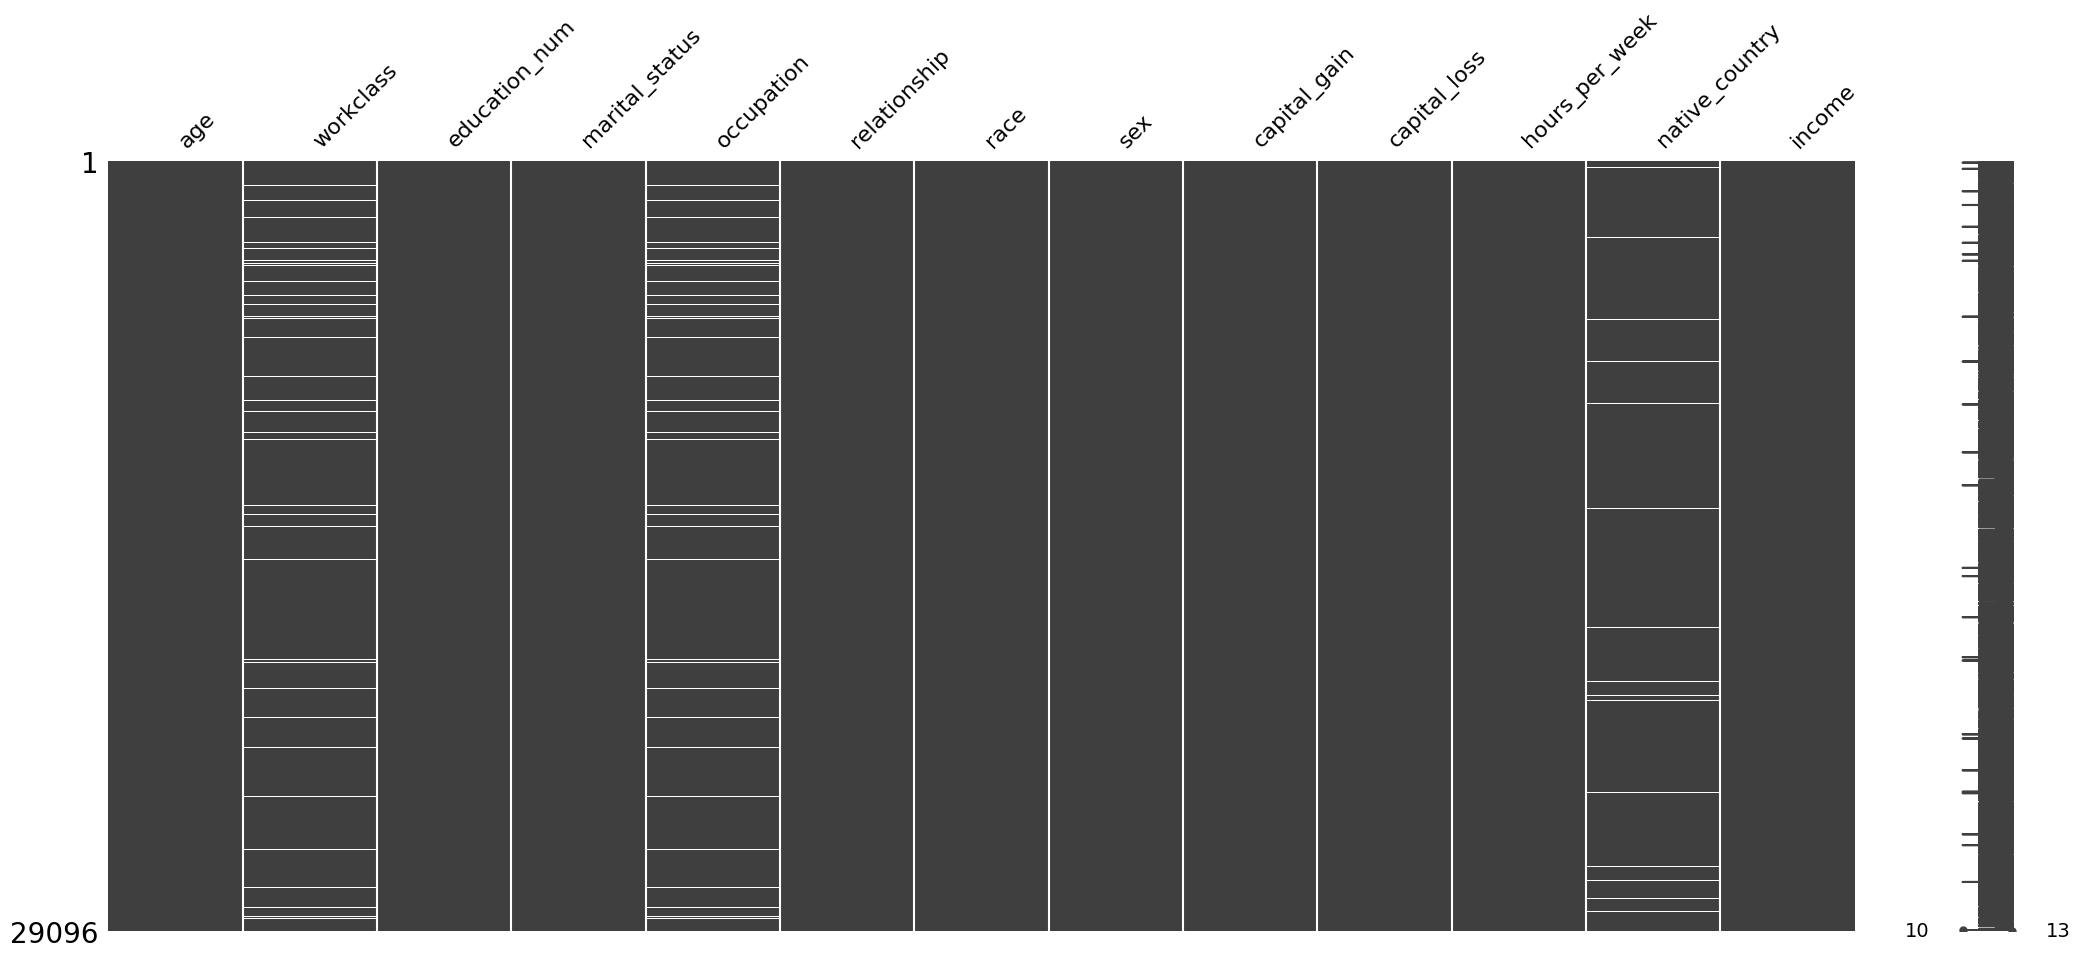

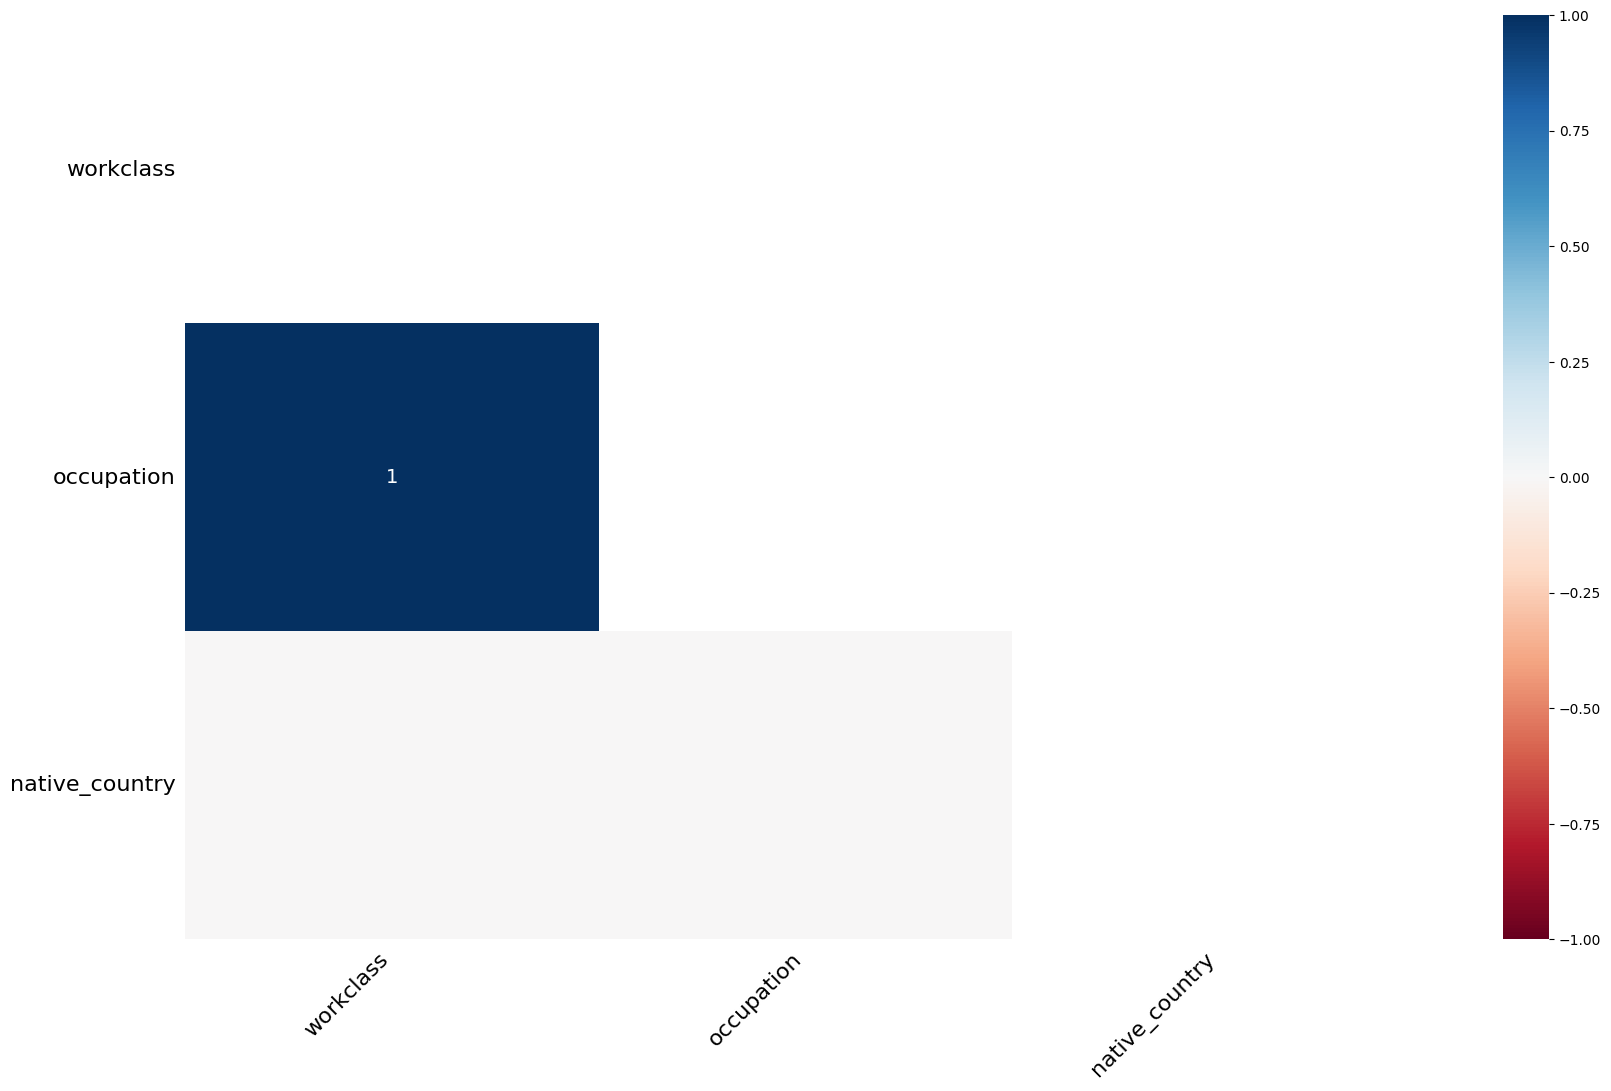

In [21]:
import missingno as msno
msno.matrix(df_train)
msno.heatmap(df_train)

In [22]:
# since ita a mar
df_train['occupation'].fillna(df_train['occupation'].mode()[0], inplace=True)
df_train['workclass'].fillna(df_train['workclass'].mode()[0], inplace=True)
df_train['native_country'].fillna(df_train['native_country'].mode()[0],inplace = True)


/tmp/ipykernel_36/909654308.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train['occupation'].fillna(df_train['occupation'].mode()[0], inplace=True)
/tmp/ipykernel_36/909654308.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [23]:
# since ita a mar
df_test['occupation'].fillna(df_test['occupation'].mode()[0], inplace=True)
df_test['workclass'].fillna(df_test['workclass'].mode()[0], inplace=True)
df_test['native_country'].fillna(df_test['native_country'].mode()[0],inplace = True)


/tmp/ipykernel_36/1110325062.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['occupation'].fillna(df_test['occupation'].mode()[0], inplace=True)
/tmp/ipykernel_36/1110325062.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [24]:
df_train.isnull().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [25]:
df_test.isnull().sum()

age               0
workclass         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [26]:
df_train.corr(numeric_only= True)

,age,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,0.030144,0.074310,0.049570,0.039831,0.215270
education_num,0.030144,1.000000,0.124182,0.080259,0.141446,0.332210
capital_gain,0.074310,0.124182,1.000000,-0.035294,0.077704,0.230696
capital_loss,0.049570,0.080259,-0.035294,1.000000,0.051636,0.153277
hours_per_week,0.039831,0.141446,0.077704,0.051636,1.000000,0.226323
income,0.215270,0.332210,0.230696,0.153277,0.226323,1.000000


In [27]:
df_train.head(1)

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0


In [28]:
df_train.columns

Index(['age', 'workclass', 'education_num', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country', 'income'],
      dtype='object')

In [29]:
print(df_train['workclass'].nunique())
print(df_train['marital_status'].nunique())
print(df_train['occupation'].nunique())
print(df_train['relationship'].nunique())
print(df_train['race'].nunique())
print(df_train['sex'].nunique())
print(df_train['native_country'].nunique())

8
7
14
6
5
2
41


In [30]:
df_train['income'].value_counts()
for i in df_test.columns:
    if df_train[i].dtypes == 'object':
        print(df_test[i].value_counts())

workclass
Private             11198
Self-emp-not-inc     1303
Local-gov            1027
State-gov             680
Self-emp-inc          572
Federal-gov           469
Without-pay             7
Never-worked            3
Name: count, dtype: int64
marital_status
Married-civ-spouse       6898
Never-married            4978
Divorced                 2132
Widowed                   525
Separated                 502
Married-spouse-absent     210
Married-AF-spouse          14
Name: count, dtype: int64
occupation
Prof-specialty       2835
Exec-managerial      1925
Craft-repair         1752
Sales                1745
Adm-clerical         1725
Other-service        1545
Machine-op-inspct     929
Transport-moving      724
Handlers-cleaners     654
Tech-support          509
Farming-fishing       489
Protective-serv       328
Priv-house-serv        93
Armed-Forces            6
Name: count, dtype: int64
relationship
Husband           6030
Not-in-family     4110
Own-child         2203
Unmarried         1643

In [31]:
def group_rare_categories(df,col,threshold):
    value_count = df[col].value_counts()
    rare_features = value_count[value_count<threshold].index
    df[col].replace(rare_features,'others',inplace =True)
    return df

In [32]:
# Example: replace rare categories in native_country
df_train = group_rare_categories(df_train, 'native_country', threshold=100)

# Replace rare categories in workclass
df_train = group_rare_categories(df_train, 'workclass', threshold=20)

# Replace rare categories in occupation
df_train = group_rare_categories(df_train, 'occupation', threshold=20)

# Replace rare categories in marital_status (if needed)
df_train = group_rare_categories(df_train, 'marital_status', threshold=20)


/tmp/ipykernel_36/2014979427.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(rare_features,'others',inplace =True)


In [33]:
# Example: replace rare categories in native_country
df_test = group_rare_categories(df_test, 'native_country', threshold=100)

# Replace rare categories in workclass
df_test = group_rare_categories(df_test, 'workclass', threshold=20)

# Replace rare categories in occupation
df_test = group_rare_categories(df_test, 'occupation', threshold=20)

# Replace rare categories in marital_status (if needed)
df_test = group_rare_categories(df_test, 'marital_status', threshold=20)


/tmp/ipykernel_36/2014979427.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace(rare_features,'others',inplace =True)


In [34]:
import category_encoders as ce
from sklearn.model_selection import KFold

def target_encoding(df,cat_col,target_col,kfold = 5):
    kf = KFold(n_splits = kfold,random_state=42,shuffle=True)
    dum_df = df.copy()
    for col in cat_col:
        dum_df[col+'_te']=0
        for train_idx,valid_idx in kf.split(df):
            train_df,val_df = df.iloc[train_idx],df.iloc[valid_idx]
            encoder = ce.TargetEncoder(cols = [col])
            encoder.fit(train_df[col],train_df[target_col])
            dum_df.iloc[valid_idx, dum_df.columns.get_loc(col + '_te')] = encoder.transform(val_df[col])[col]

    return dum_df

In [35]:
cat_cols = [i for i in df_train.columns if df_train[i].dtype == 'object']
print(cat_cols)


['workclass', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']


In [36]:
df_encoded = target_encoding(df_train, cat_cols, 'income')

/tmp/ipykernel_36/2132369232.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.21766228 0.21766228 0.21766228 ... 0.29120198 0.21766228 0.21766228]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dum_df.iloc[valid_idx, dum_df.columns.get_loc(col + '_te')] = encoder.transform(val_df[col])[col]
/tmp/ipykernel_36/2132369232.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.45663002 0.07668712 0.05544148 ... 0.10864417 0.10864417 0.45663002]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dum_df.iloc[valid_idx, dum_df.columns.get_loc(col + '_te')] = encoder.transform(val_df[col])[col]
/tmp/ipykernel_36/2132369232.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of 

In [37]:
test_encoded = target_encoding(df_test, cat_cols, 'income')

/tmp/ipykernel_36/2132369232.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.2080582 0.2080582 0.2080582 ... 0.2080582 0.2080582 0.2080582]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dum_df.iloc[valid_idx, dum_df.columns.get_loc(col + '_te')] = encoder.transform(val_df[col])[col]
/tmp/ipykernel_36/2132369232.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.04696624 0.45093795 0.04696624 ... 0.09590643 0.04696624 0.09590643]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dum_df.iloc[valid_idx, dum_df.columns.get_loc(col + '_te')] = encoder.transform(val_df[col])[col]
/tmp/ipykernel_36/2132369232.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas

In [38]:
x = df_encoded.select_dtypes(include = ['number'])
x_train = x.drop(columns=['income'])
y_train = x['income']

In [39]:
x.shape

(29096, 13)

In [40]:
x = test_encoded.select_dtypes(include = ['number'])
x_test = x.drop(columns=['income'])
y_test = x['income']

In [41]:
x.shape

(15259, 13)

Text(0, 0.5, 'Scores')

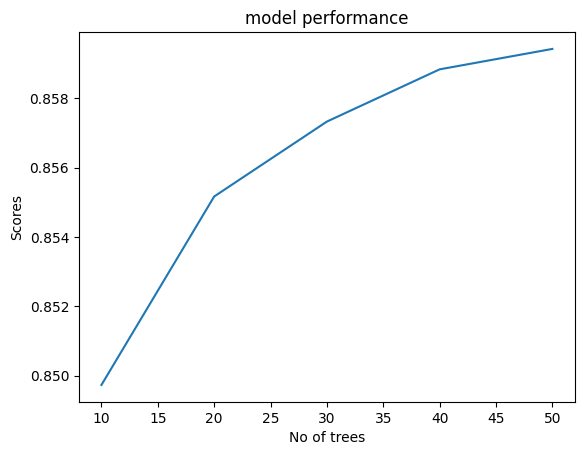

In [42]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
tree_counts = [10,20,30,40,50]
scores = []
for i in tree_counts:
    model = RandomForestClassifier(n_estimators = i,random_state = 42)
    model.fit(x_train,y_train)
    scores.append(model.score(x_test,y_test))
    
plt.plot(tree_counts,scores)
plt.title('model performance')
plt.xlabel('No of trees')
plt.ylabel('Scores')

In [43]:
model = RandomForestClassifier(n_estimators = 20,max_depth = 10,class_weight='balanced',random_state = 42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [44]:
print(f'test_accuracy {model.score(x_test,y_test):.4f}')
print(f'train_accuracy {model.score(x_train,y_train):.4f}')

test_accuracy 0.8252
train_accuracy 0.8379


In [45]:
importance = model.feature_importances_
sorted_imp = importance.argsort()
for i in sorted_imp[::-1]:
    print(f'featute {x_train.columns[i]} : {importance[i]:.4f}')

featute relationship_te : 0.2868
featute marital_status_te : 0.1655
featute capital_gain : 0.1465
featute education_num : 0.1183
featute occupation_te : 0.0851
featute age : 0.0736
featute hours_per_week : 0.0525
featute capital_loss : 0.0309
featute workclass_te : 0.0123
featute sex_te : 0.0119
featute native_country_te : 0.0093
featute race_te : 0.0074


In [46]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.94      0.82      0.88     11604
           1       0.60      0.83      0.69      3655

    accuracy                           0.83     15259
   macro avg       0.77      0.83      0.79     15259
weighted avg       0.86      0.83      0.83     15259



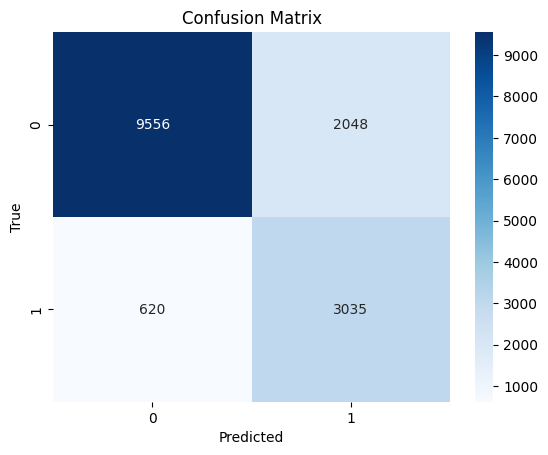

In [47]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [59]:
explainer = shap.TreeExplainer(model)
shap_value = explainer.shap_values(x_test)

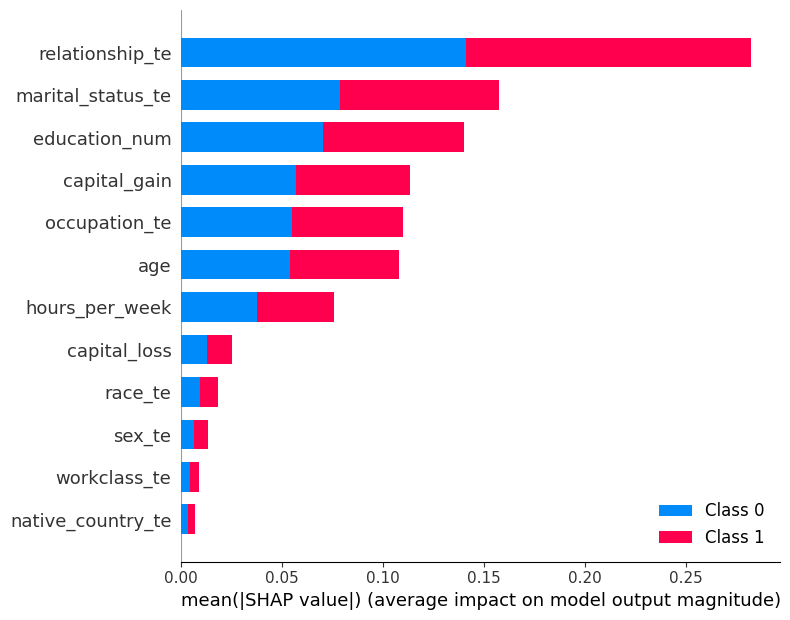

In [61]:
shap.summary_plot(shap_value,x_test)

In [68]:
len(shap_value)

2

In [71]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_value[1][0,:], x_test.iloc[0,:])

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys 

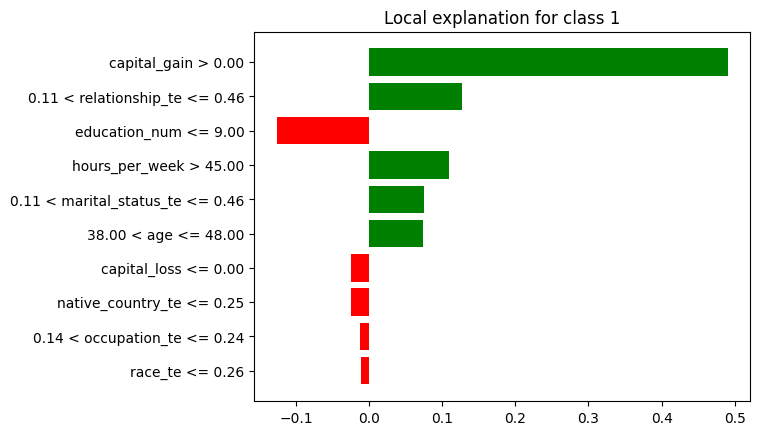

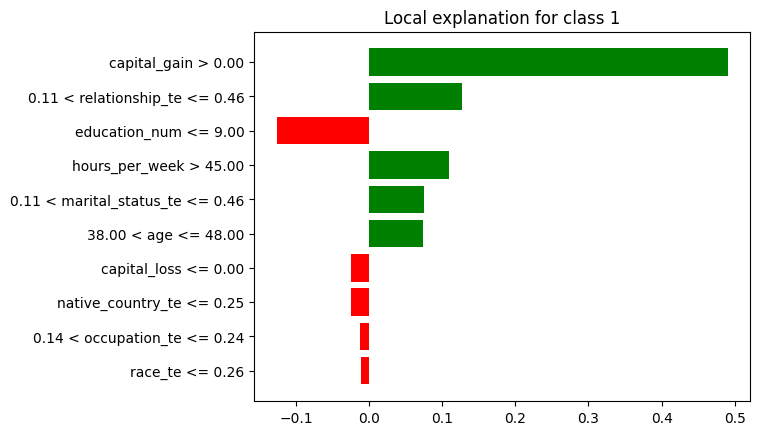

In [77]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = np.array(x_train),
    feature_names = x_train.columns,
    class_names = [0,1],
    mode = 'classification'
)
i = 25 #instance
exp = explainer.explain_instance(
    data_row = x_test.iloc[i],
    predict_fn = model.predict_proba
)
exp.show_in_notebook(show_table = True)
exp.as_pyplot_figure()

In [80]:
pip install alibi

INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 98.1 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.4 MB/s eta 

In [101]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = [i for i in df_train.columns if df_train[i].dtypes == 'object' and i != 'income']
continuous = [i for i in df_train.columns if df_train[i].dtypes != 'object' and i != 'income']


In [102]:
categorical_features

['workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [103]:
X_train = df_train.drop(columns = ['income'])
Y_train = df_train['income']
X_test  = df_test.drop(columns = ['income'])
Y_test = df_test['income']

In [104]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features),
        ('num', 'passthrough', continuous)
    ]
)

In [108]:
from sklearn.pipeline import Pipeline
rf = RandomForestClassifier(n_estimators=30, random_state=0,max_depth = 6)
model_pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', rf)])
model_pipe.fit(X_train, Y_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country']),
                                                 ('num', 'passthrough',
                                                  ['age', 'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])])),
                ('clf',
                 RandomForestClassifier(max_depth=6, n_estimators=30,
                                        random_state=0))])

In [109]:
print('train score ', model_pipe.score(X_train,Y_train))
print('test score ', model_pipe.score(X_test,Y_test))

train score  0.8527976354138026
test score  0.8525460384035651


In [114]:
import dice_ml
from dice_ml import Dice

d = dice_ml.Data(
    dataframe=df_train, 
    continuous_features=['age','hours_per_week','capital_gain','capital_loss','education_num'],
    categorical_features=['workclass','marital_status','occupation','relationship','race','sex','native_country'],
    outcome_name='income'
)
m = dice_ml.Model(model=model_pipe, backend="sklearn")  
exp = Dice(d, m, method="random")


query = X_test.iloc[[25]]     # pandas DataFrame slice
cf = exp.generate_counterfactuals(query, total_CFs=3, desired_class="opposite")
cf.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

Query instance (original outcome : 1)


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,45,Self-emp-not-inc,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,90,United-States,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,45,Self-emp-not-inc,9,Married-civ-spouse,Craft-repair,Other-relative,White,Male,7298,0,13,United-States,0
1,45,Self-emp-not-inc,9,Divorced,Craft-repair,Own-child,White,Male,7298,0,90,United-States,0
2,45,Self-emp-not-inc,9,Married-civ-spouse,Craft-repair,Husband,White,Male,3487,0,90,United-States,0


In [48]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators = 30,
    learning_rate = 0.05,
    max_depth = 6,
    scale_pos_weight = 3.04,# no of negative sample/no of positive sample
    subsample = 0.8,#bagging
    colsample_bytree = 0.8,#how much percentage of feature to be used in the bagging.
    objective='binary:logistic'
)

In [49]:
xgb_model.fit(x_train,y_train)
y_pred = xgb_model.predict(x_test)

In [50]:
print(f'test_accuracy {xgb_model.score(x_test,y_test):.4f}')
print(f'train_accuracy {xgb_model.score(x_train,y_train):.4f}')

test_accuracy 0.8266
train_accuracy 0.8203


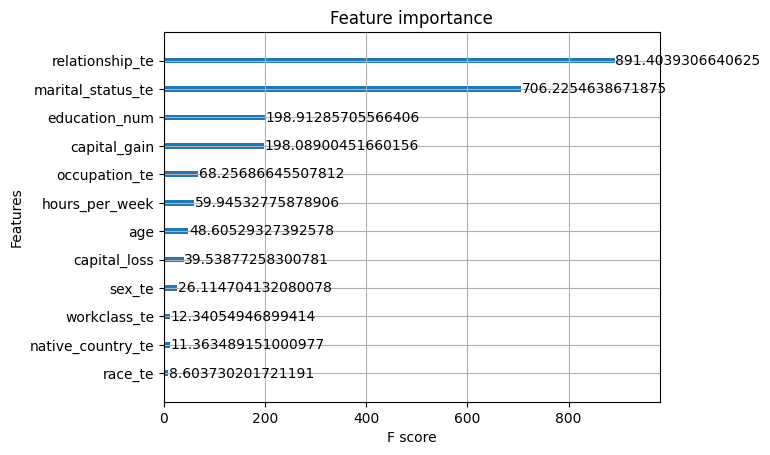

In [51]:
xgb.plot_importance(xgb_model, importance_type='gain')  # You can use 'weight', 'gain', or 'cover'
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

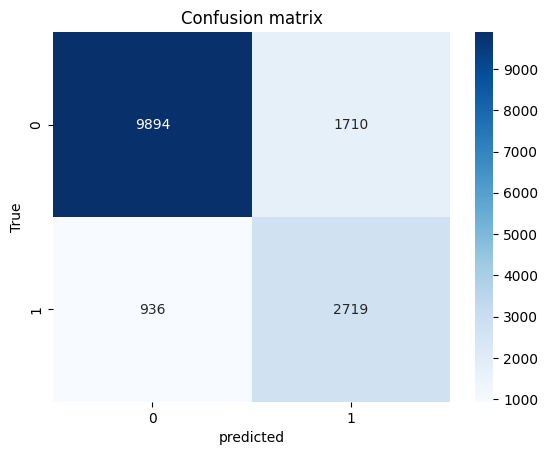

In [52]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues')
plt.ylabel('True')
plt.xlabel('predicted')
plt.title('Confusion matrix')

In [53]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

           0       0.91      0.85      0.88     11604
           1       0.61      0.74      0.67      3655

    accuracy                           0.83     15259
   macro avg       0.76      0.80      0.78     15259
weighted avg       0.84      0.83      0.83     15259



In [54]:
df_train['income'].value_counts()

income
0    21886
1     7210
Name: count, dtype: int64

In [55]:
21886/7210

3.035506241331484

In [56]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_value = explainer.shap_values(x_test)

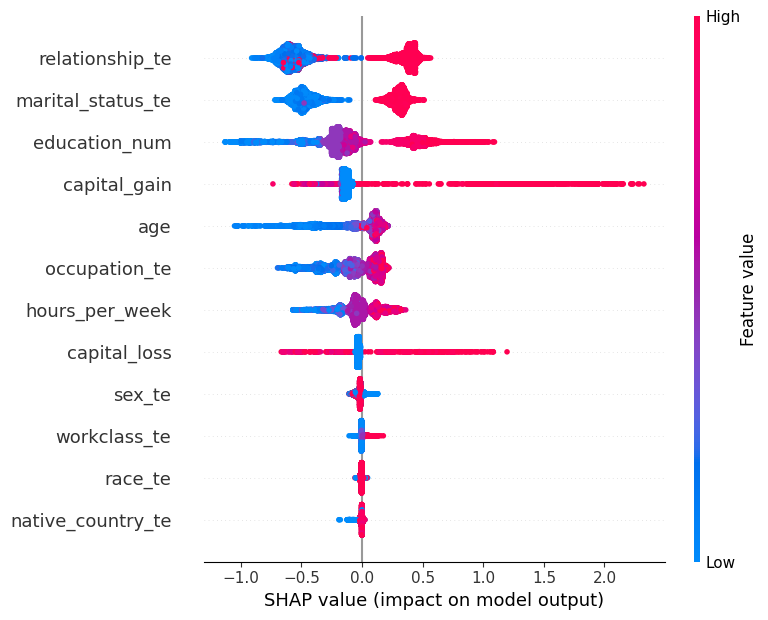

In [57]:
shap.summary_plot(shap_value, x_test)

In [58]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_value[0,:], x_test.iloc[0,:])

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels

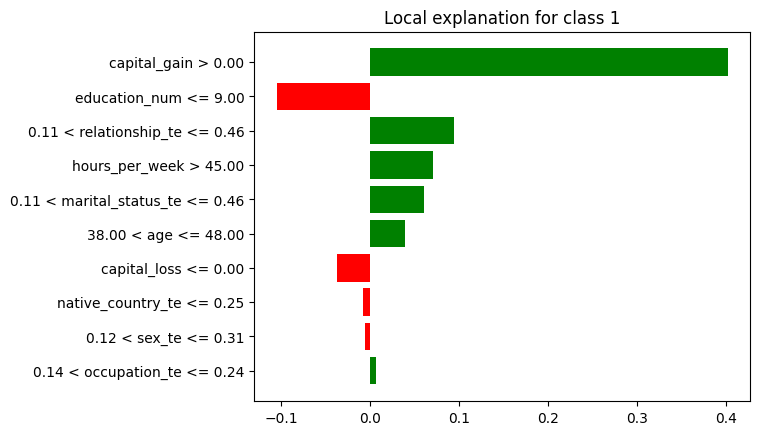

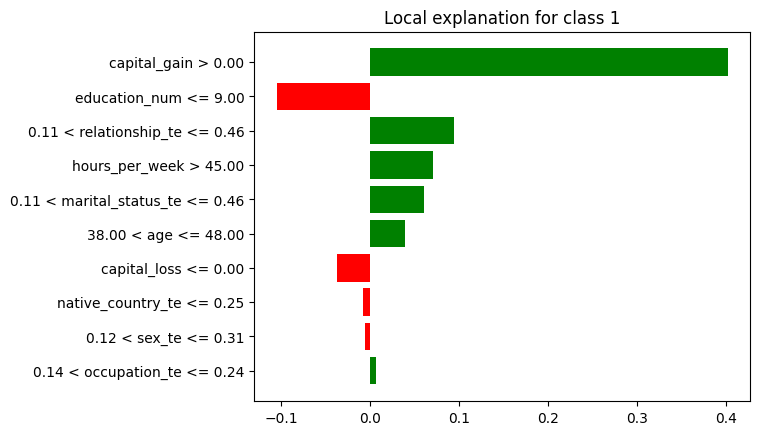

In [78]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = np.array(x_train),
    feature_names = x_train.columns,
    class_names = [0,1],
    mode = 'classification'
)
i = 25 #instance
exp = explainer.explain_instance(
    data_row = x_test.iloc[i],
    predict_fn = xgb_model.predict_proba
)
exp.show_in_notebook(show_table = True)
exp.as_pyplot_figure()

In [115]:
from sklearn.preprocessing import OneHotEncoder
categorical_features = [i for i in df_train.columns if df_train[i].dtypes == 'object' and i != 'income']
continuous = [i for i in df_train.columns if df_train[i].dtypes != 'object' and i != 'income']

In [116]:
X_train = df_train.drop(columns = ['income'])
Y_train = df_train['income']
X_test  = df_test.drop(columns = ['income'])
Y_test = df_test['income']

In [117]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features),
        ('num', 'passthrough', continuous)
    ]
)

In [118]:
from sklearn.pipeline import Pipeline
import xgboost as xgb
xg_boost = xgb.XGBClassifier(
    n_estimators = 30,
    learning_rate = 0.05,
    max_depth = 6,
    scale_pos_weight = 3.04,# no of negative sample/no of positive sample
    subsample = 0.8,#bagging
    colsample_bytree = 0.8,#how much percentage of feature to be used in the bagging.
    objective='binary:logistic'
)


model_pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', xg_boost)])
model_pipe.fit(X_train, Y_train)

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native_country']),
                                                 ('num', 'passthrough',
                                                  ['age', 'education_num',
                                                   'capital_gain',
                                                   'capital_loss',
                                                   'hours_per_week'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=N...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=30, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [119]:
print('train score ', model_pipe.score(X_train,Y_train))
print('test score ', model_pipe.score(X_test,Y_test))


train score  0.8103519384107781
test score  0.8029359722131201


In [120]:
import dice_ml
from dice_ml import Dice

d = dice_ml.Data(
    dataframe=df_train, 
    continuous_features=['age','hours_per_week','capital_gain','capital_loss','education_num'],
    categorical_features=['workclass','marital_status','occupation','relationship','race','sex','native_country'],
    outcome_name='income'
)
m = dice_ml.Model(model=model_pipe, backend="sklearn")  
exp = Dice(d, m, method="random")


query = X_test.iloc[[25]]     # pandas DataFrame slice
cf = exp.generate_counterfactuals(query, total_CFs=3, desired_class="opposite")
cf.visualize_as_dataframe()


100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

Query instance (original outcome : 1)


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,45,Self-emp-not-inc,9,Married-civ-spouse,Craft-repair,Husband,White,Male,7298,0,90,United-States,1



Diverse Counterfactual set (new outcome: 0)


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,45,Self-emp-not-inc,9,Married-spouse-absent,Craft-repair,Husband,White,Male,5930,0,90,United-States,0
1,45,Self-emp-not-inc,9,Married-spouse-absent,Craft-repair,Husband,White,Male,6068,0,90,United-States,0
2,18,Self-emp-not-inc,9,Divorced,Craft-repair,Other-relative,White,Male,7298,0,90,United-States,0
